## Machine Learning Pipeline: Wrapping up for Deployment


In the previous notebooks, we worked through the typical Machine Learning pipeline steps to build a regression model that allows us to predict house prices. Briefly, we transformed variables in the dataset to make them suitable for use in a Regression model, then we selected the most predictive variables and finally we trained our model.

Now, we want to deploy our model. We want to create an API, which we can call with new data, with new characteristics about houses, to get an estimate of the price. In order to do so, we need to write code in a very specific way.

Here, we will summarise the key pieces of code, that we need to take forward for this particular project, to put our model in production.

Let's go ahead and get started.

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# to divide train and test set
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

## Load data

We need the training data to train our model in the production environment. 

In [2]:
# load dataset
data = pd.read_csv('../dataset/housing_train.csv')
print(data.shape)
data.head()

(265190, 22)


,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7039061606,https://bham.craigslist.org/apa/d/birmingham-h...,birmingham,https://bham.craigslist.org,1195,apartment,1908,3,2.0,1,1,1,0,0,0,laundry on site,street parking,https://images.craigslist.org/00L0L_80pNkyDeG0...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
1,7041970863,https://bham.craigslist.org/apa/d/birmingham-w...,birmingham,https://bham.craigslist.org,1120,apartment,1319,3,2.0,1,1,1,0,0,0,laundry on site,off-street parking,https://images.craigslist.org/00707_uRrY9CsNMC...,Find Your Way to Haven Apartment Homes Come ho...,33.3755,-86.8045,al
2,7041966914,https://bham.craigslist.org/apa/d/birmingham-g...,birmingham,https://bham.craigslist.org,825,apartment,1133,1,1.5,1,1,1,0,0,0,laundry on site,street parking,https://images.craigslist.org/00h0h_b7Bdj1NLBi...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
3,7041966936,https://bham.craigslist.org/apa/d/birmingham-f...,birmingham,https://bham.craigslist.org,800,apartment,927,1,1.0,1,1,1,0,0,0,laundry on site,street parking,https://images.craigslist.org/00808_6ghZ8tSRQs...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
4,7041966888,https://bham.craigslist.org/apa/d/birmingham-2...,birmingham,https://bham.craigslist.org,785,apartment,1047,2,1.0,1,1,1,0,0,0,laundry on site,street parking,https://images.craigslist.org/00y0y_21c0FOvUXm...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al


In [3]:
data.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'type', 'sqfeet', 'beds',
       'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'laundry_options', 'parking_options', 'image_url', 'description', 'lat',
       'long', 'state'],
      dtype='object')

In [4]:
data.isna().mean().sort_values(ascending=False)

parking_options            0.358743
laundry_options            0.204800
lat                        0.005351
long                       0.005351
description                0.000008
state                      0.000004
beds                       0.000000
url                        0.000000
region                     0.000000
region_url                 0.000000
price                      0.000000
type                       0.000000
sqfeet                     0.000000
dogs_allowed               0.000000
baths                      0.000000
cats_allowed               0.000000
smoking_allowed            0.000000
wheelchair_access          0.000000
electric_vehicle_charge    0.000000
comes_furnished            0.000000
image_url                  0.000000
id                         0.000000
dtype: float64

## Data Cleaning

Creating new features from already existing features. Also exploring the description for more insightful features

In [5]:
data['premium_house'] = np.where((data['baths']>=data['beds'])&(data['beds']>1),1,0)
data['pets_allowed'] = np.where((data['cats_allowed']==1)&data['dogs_allowed']==1,1,0)


data['beds_per_sqfeet'] = data.apply(lambda x: (x.beds / x.sqfeet) if x.sqfeet != 0 else 0, axis=1)
data['baths_per_beds'] = data.apply(lambda x: (x.baths / x.beds) if x.beds != 0 else 0, axis=1)


data = data.dropna(subset=['description','state'],axis=0)


data['has_pool'] = data['description'].apply(
    lambda x: 1 if 'pool' in x.lower() 
    or 'swimming' in x.lower() 
    else 0)

data['has_grill'] = data['description'].apply(
    lambda x: 1 if 'grill' in x.lower() 
    or 'grilling' in x.lower() 
    else 0)

data['has_fireplace'] = data['description'].apply(
    lambda x: 1 if 'fireplace' in x.lower() 
    or 'fire pits' in x.lower() 
    else 0)

data['gym_nearby'] = data['description'].apply(
    lambda x: 1 if 'gym' in x.lower() 
    or 'fitness' in x.lower() 
    else 0)

data['school/clg_nearby'] = data['description'].apply(
    lambda x: 1 if 'school' in x.lower() 
    or 'college' in x.lower() 
    else 0)

data['wifi_facilities'] = data['description'].apply(
    lambda x: 1 if 'wifi' in x.lower() 
    or 'wi-fi' in x.lower() 
    else 0)

data['valet_service'] = data['description'].apply(
    lambda x: 1 if 'valet' in x.lower() 
    else 0)

data['shopping_nearby'] = data['description'].apply(
    lambda x: 1 if 'shopping' in x.lower() 
    else 0)

data['sports_playground'] = data['description'].apply(
    lambda x: 1 if 'sport' in x.lower()  
    or 'sports' in x.lower() 
    or 'tennis' in x.lower() 
    or 'soccer' in x.lower() 
    or 'soccers' in x.lower() 
    or 'court' in x.lower() 
    else 0)

data['dining_nearby'] = data['description'].apply(
    lambda x: 1 if 'dining' in x.lower() 
    else 0)

## Outliers

In EDA, we decided to remove outliers according to the upper and lower bound of its interquartile range.

In [6]:
outliers_vars = ['sqfeet', 'price', 'beds', 'baths']

In [7]:
def out_iqr(df , column):
    global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    return np.ceil(q25 - cut_off), np.ceil(q75 + cut_off)
#     return lower, upper

In [8]:
for var in outliers_vars:
    _, upper = out_iqr(data, var)
    lower = 1
    data = data[(data[var] <= upper) & (data[var] >= lower)]

## Engineer missing values

### Categorical variables

For categorical variables, we will replace missing values with the mode of relevant features

In [9]:
data.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'type', 'sqfeet', 'beds',
       'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'laundry_options', 'parking_options', 'image_url', 'description', 'lat',
       'long', 'state', 'premium_house', 'pets_allowed', 'beds_per_sqfeet',
       'baths_per_beds', 'has_pool', 'has_grill', 'has_fireplace',
       'gym_nearby', 'school/clg_nearby', 'wifi_facilities', 'valet_service',
       'shopping_nearby', 'sports_playground', 'dining_nearby'],
      dtype='object')

In [10]:
data.isna().mean().sort_values(ascending=False)

parking_options            0.368638
laundry_options            0.205216
lat                        0.004608
long                       0.004608
cats_allowed               0.000000
comes_furnished            0.000000
electric_vehicle_charge    0.000000
wheelchair_access          0.000000
smoking_allowed            0.000000
dogs_allowed               0.000000
dining_nearby              0.000000
beds                       0.000000
sqfeet                     0.000000
type                       0.000000
price                      0.000000
region_url                 0.000000
region                     0.000000
url                        0.000000
baths                      0.000000
image_url                  0.000000
sports_playground          0.000000
description                0.000000
state                      0.000000
premium_house              0.000000
pets_allowed               0.000000
beds_per_sqfeet            0.000000
baths_per_beds             0.000000
has_pool                   0

In [11]:
# make a list of the categorical variables that contain missing values
cat_var_na = ['laundry_options', 'parking_options']

Note that we have much less categorical variables with missing values than in our original dataset. But we still use categorical variables with NA for the final model, so we need to include this piece of feature engineering logic in the deployment pipeline. 

In [12]:
# I bring forward the code used in the feature engineering notebook:
# (step 2)

def impute_missing_cat(data, vars, replace_by='type'):
    for var in vars:
        data[var] = data.groupby(replace_by)[var].transform(
                    lambda x: x.fillna(x.mode()[0]))
    return data

data = impute_missing_cat(data,cat_var_na)


# check that we have no missing information in the engineered variables
data[cat_var_na].isnull().sum()

laundry_options    0
parking_options    0
dtype: int64

### Numerical variables

To engineer missing values in numerical variables, we will:

- add a binary missing value indicator variable
- and then replace the missing values in the original variable with the mean of relevant features


In [13]:
# make a list of the numerical variables that contain missing values:
num_var_na = ['lat', 'long']

In [14]:
# I bring forward the code used in the feature engineering notebook
# with minor adjustments (step 2):

# replace missing values by the mean
for var in num_var_na:
    data[var] = data.groupby('region')[var].transform(
                    lambda x: x.fillna(x.mode()[0]))
    
# check that we have no missing information in the engineered variables
data[num_var_na].isnull().sum()

lat     0
long    0
dtype: int64

## Numerical variable transformation

We will log transform the positive numerical variables in order to get a more Gaussian-like distribution. This tends to help Linear machine learning models. 

In [15]:
for var in ['price','sqfeet','baths_per_beds','beds_per_sqfeet']:
    data[var] = np.log(data[var])

In [16]:
# check that data set does not contain null values in the engineered variables
[var for var in ['price','sqfeet','baths_per_beds','beds_per_sqfeet'] if data[var].isnull().sum() > 0]

[]

## Categorical variables

### Group rare labels

In [17]:
# let's capture the categorical variables in a list

cat_vars = ['region', 'type', 'laundry_options', 'parking_options', 'state']

In [18]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var)['price'].count() / len(df)

    return tmp[tmp > rare_perc].index


for var in cat_vars:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(data, var, 0.01)
    # replace rare categories by the string "Rare"
    data[var] = np.where(data[var].isin(
        frequent_ls), data[var], 'Rare')

### Encoding of categorical variables

In [19]:
# this function will assign discrete values to the strings of the variables,
# so that the smaller value corresponds to the category that shows the smaller
# mean house sale price


def replace_categories(data, var, target):

    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = data.groupby([var])[target].mean().sort_values().index
    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
    # use the dictionary to replace the categorical strings by integers
    data[var] = data[var].map(ordinal_label)

In [20]:
for var in cat_vars:
    replace_categories(data, var, 'price')

In [21]:
# check absence of na in the train set
[var for var in data.columns if data[var].isnull().sum() > 0]

[]

In [22]:
data.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'type', 'sqfeet', 'beds',
       'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'laundry_options', 'parking_options', 'image_url', 'description', 'lat',
       'long', 'state', 'premium_house', 'pets_allowed', 'beds_per_sqfeet',
       'baths_per_beds', 'has_pool', 'has_grill', 'has_fireplace',
       'gym_nearby', 'school/clg_nearby', 'wifi_facilities', 'valet_service',
       'shopping_nearby', 'sports_playground', 'dining_nearby'],
      dtype='object')

In [23]:
features = ['region', 'price', 'type', 'sqfeet', 'smoking_allowed', 'wheelchair_access', 'electric_vehicle_charge', 
            'comes_furnished', 'laundry_options', 'parking_options','lat', 'long', 'state', 
            'premium_house', 'pets_allowed', 'beds_per_sqfeet', 'baths_per_beds', 'has_pool', 'has_grill', 
            'has_fireplace', 'gym_nearby', 'school/clg_nearby', 'wifi_facilities', 'valet_service', 'shopping_nearby', 
            'sports_playground', 'dining_nearby']

data_final = data[features].copy()
data_final.head()

,region,price,type,sqfeet,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,lat,long,state,premium_house,pets_allowed,beds_per_sqfeet,baths_per_beds,has_pool,has_grill,has_fireplace,gym_nearby,school/clg_nearby,wifi_facilities,valet_service,shopping_nearby,sports_playground,dining_nearby
1,7,7.021976,3,7.185387,1,0,0,0,1,0,33.3755,-86.8045,7,0,1,0.002272,0.510826,0,0,0,0,1,0,0,1,0,0
2,7,6.716595,3,7.033506,1,0,0,0,1,1,33.4226,-86.7065,7,0,1,0.000882,0.916291,1,1,1,1,1,0,1,1,1,1
3,7,6.685861,3,6.833032,1,0,0,0,1,1,33.4226,-86.7065,7,0,1,0.001078,0.693147,1,1,1,1,1,0,1,1,1,1
4,7,6.666957,3,6.954639,1,0,0,0,1,1,33.4226,-86.7065,7,0,1,0.001908,0.405465,1,1,1,1,1,0,1,1,1,1
5,7,6.803505,3,7.169350,1,0,0,0,1,1,33.4226,-86.7065,7,1,1,0.001540,0.693147,1,1,1,0,1,0,1,1,1,1


## Train-Test Split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
                                    data_final.drop('price',axis=1),
                                    data_final['price'],
                                    test_size=0.25,
                                    random_state=0)

## Random Forest

***Model Training***

In [25]:
# set up the model
# remember to set the random_state / seed

rf = RandomForestRegressor(n_estimators=200,
                           random_state=101)

# train the model
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=101, verbose=0,
                      warm_start=False)

***Predictions***

In [26]:
rf_pred_train = rf.predict(X_train)
rf_pred_test = rf.predict(X_test)

***Evaluation***

Random Forest Performance:

all features, No scaling(train):
Train MAE: 0.027401273766956568
Train MSE: 3616.437146075584
Train RMSE: 0.08061006352262472
R2_Score:  0.9702952417140144

all features, No scaling(test):
Test MAE: 0.05957194294751777
Test MSE: 18104.68533364217
Test RMSE: 0.17789437266294272
R2_Score:  0.8561947831372538


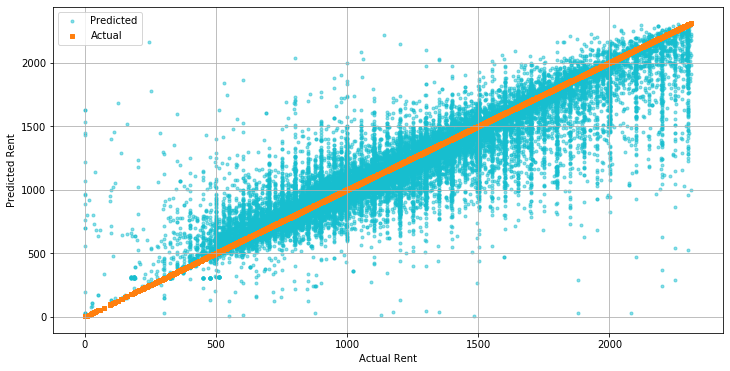

In [27]:
print('Random Forest Performance:')

print('\nall features, No scaling(train):')
print('Train MSE:', mean_squared_error(np.exp(y_train), np.exp(rf_pred_train)))
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, rf_pred_train)))
print('Train MAE:', mean_absolute_error(y_train, rf_pred_train))
print('R2_Score: ', r2_score(y_train, rf_pred_train))

print('\nall features, No scaling(test):')
print('Test MSE:', mean_squared_error(np.exp(y_test), np.exp(rf_pred_test)))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, rf_pred_test)))
print('Test MAE:', mean_absolute_error(y_test, rf_pred_test))
print('R2_Score: ', r2_score(y_test, rf_pred_test))


# pred = pd.DataFrame(data={'Predicted_Rent': np.exp(rf_pred_test), 'Actual_Rent': np.exp(y_test)})

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(np.exp(y_test), np.exp(rf_pred_test), color='tab:cyan', marker=".", label='Predicted', alpha='0.5')
ax1.scatter(np.exp(y_test), np.exp(y_test), s=10, color='tab:orange', marker="s", label='Actual')


plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(loc='upper left');
plt.grid()
plt.show()